# AQI空气污染指数预测建模——回归

AQI，空气污染指数，就是根据环境空气质量标准和各项污染物对人体健康、生态、环境的影响，将常规监测的几种空气污染物浓度简化成为单一的概念性指数值形式，它将空气污染程度和空气质量状况分级表示，适合于表示城市的短期空气质量状况和变化趋势。针对单项污染物的还规定了空气质量分指数。参与空气质量评价的主要污染物为细颗粒物（PM2.5）、可吸入颗粒物(PM10)、二氧化硫、二氧化氮、臭氧、一氧化碳等六项。

AQI的取值范围定为0～500，其中0～50、51～100、101～200、201～300和大于300，分别对应国家空气质量标准中日均值的 I级、II级、III级、IV级和V级标准的污染物浓度限定数值。指数越大，级别越高，说明污染越严重。

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
# Configure visualisations
sns.set_style()

In [2]:
data=pd.read_csv('train.csv')

In [3]:
data.columns

Index(['datetime', 'STATIONNAME', 'AQI', 'PM2.5', 'PM10', 'NO2', 'O3', 'CO',
       'SO2'],
      dtype='object')

In [4]:
data.head()

,datetime,STATIONNAME,AQI,PM2.5,PM10,NO2,O3,CO,SO2
0,2015/1/2 1:00,A1,145.0,111.0,140.0,102.0,2.0,2.7,61.0
1,2015/1/2 1:00,A2,130.0,99.0,177.0,64.0,16.0,3.0,44.0
2,2015/1/2 1:00,A3,85.0,34.0,120.0,10.0,56.0,0.4,10.0
3,2015/1/2 1:00,A4,109.0,82.0,154.0,90.0,5.0,3.4,46.0
4,2015/1/2 1:00,A5,127.0,96.0,132.0,89.0,4.0,3.4,62.0


In [5]:
data.tail()

,datetime,STATIONNAME,AQI,PM2.5,PM10,NO2,O3,CO,SO2
65455,2015/8/31 23:00,A8,19.0,5.0,5.0,2.0,58.0,0.5,2.0
65456,2015/8/31 23:00,A9,24.0,9.0,NaN,17.0,75.0,0.5,2.0
65457,2015/8/31 23:00,A10,21.0,6.0,18.0,5.0,66.0,0.4,2.0
65458,2015/8/31 23:00,A11,22.0,8.0,NaN,26.0,70.0,0.6,2.0
65459,2015/8/31 23:00,A12,25.0,17.0,NaN,19.0,77.0,0.5,2.0


In [6]:
data.describe()

,AQI,PM2.5,PM10,NO2,O3,CO,SO2
count,64118.000000,63368.000000,46308.000000,63247.000000,63563.000000,63760.000000,63752.000000
mean,104.692848,71.916709,108.114775,44.157051,71.874156,1.098774,14.379455
std,80.137977,66.828762,92.643884,31.447167,60.516739,1.036241,19.299763
min,4.000000,3.000000,5.000000,2.000000,2.000000,0.100000,2.000000
25%,44.000000,21.000000,43.000000,20.000000,25.000000,0.500000,2.000000
50%,84.000000,52.000000,88.000000,36.000000,62.000000,0.800000,6.000000
75%,139.000000,102.000000,147.000000,62.000000,98.000000,1.300000,18.000000
max,500.000000,762.000000,1040.000000,214.000000,423.000000,14.000000,500.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65460 entries, 0 to 65459
Data columns (total 9 columns):
datetime       65460 non-null object
STATIONNAME    65460 non-null object
AQI            64118 non-null float64
PM2.5          63368 non-null float64
PM10           46308 non-null float64
NO2            63247 non-null float64
O3             63563 non-null float64
CO             63760 non-null float64
SO2            63752 non-null float64
dtypes: float64(7), object(2)
memory usage: 4.5+ MB


由于数据也是个时间序列，所以我们可以先大致看一下AQI在不同时间尺度下的趋势。字段中date和time在一起，我们首先要把他们拆分开来看。

In [8]:
temp=pd.DatetimeIndex(data['datetime'])
data['date']=temp.date
data['time']=temp.time

In [9]:
data.head()

,datetime,STATIONNAME,AQI,PM2.5,PM10,NO2,O3,CO,SO2,date,time
0,2015/1/2 1:00,A1,145.0,111.0,140.0,102.0,2.0,2.7,61.0,2015-01-02,01:00:00
1,2015/1/2 1:00,A2,130.0,99.0,177.0,64.0,16.0,3.0,44.0,2015-01-02,01:00:00
2,2015/1/2 1:00,A3,85.0,34.0,120.0,10.0,56.0,0.4,10.0,2015-01-02,01:00:00
3,2015/1/2 1:00,A4,109.0,82.0,154.0,90.0,5.0,3.4,46.0,2015-01-02,01:00:00
4,2015/1/2 1:00,A5,127.0,96.0,132.0,89.0,4.0,3.4,62.0,2015-01-02,01:00:00


同样，我们也可以把Month、Week、Day和Hour拆分出来。

In [10]:
data['month']=temp.month
data['day']=temp.day
data['hour']=temp.hour
data['week']=temp.weekofyear
data.head()

,datetime,STATIONNAME,AQI,PM2.5,PM10,NO2,O3,CO,SO2,date,time,month,day,hour,week
0,2015/1/2 1:00,A1,145.0,111.0,140.0,102.0,2.0,2.7,61.0,2015-01-02,01:00:00,1,2,1,1
1,2015/1/2 1:00,A2,130.0,99.0,177.0,64.0,16.0,3.0,44.0,2015-01-02,01:00:00,1,2,1,1
2,2015/1/2 1:00,A3,85.0,34.0,120.0,10.0,56.0,0.4,10.0,2015-01-02,01:00:00,1,2,1,1
3,2015/1/2 1:00,A4,109.0,82.0,154.0,90.0,5.0,3.4,46.0,2015-01-02,01:00:00,1,2,1,1
4,2015/1/2 1:00,A5,127.0,96.0,132.0,89.0,4.0,3.4,62.0,2015-01-02,01:00:00,1,2,1,1


这里涉及到的STATIONNAME，也就是地点比较多，为方便从时间角度分析AQI的变化趋势，以A3地点为例进行说明。

In [11]:
data_A3=data[data['STATIONNAME'].str.contains('A3')]
data_A3.head()

,datetime,STATIONNAME,AQI,PM2.5,PM10,NO2,O3,CO,SO2,date,time,month,day,hour,week
2,2015/1/2 1:00,A3,85.0,34.0,120.0,10.0,56.0,0.4,10.0,2015-01-02,01:00:00,1,2,1,1
14,2015/1/2 2:00,A3,73.0,15.0,96.0,4.0,66.0,0.2,4.0,2015-01-02,02:00:00,1,2,2,1
26,2015/1/2 3:00,A3,67.0,13.0,83.0,4.0,67.0,0.3,5.0,2015-01-02,03:00:00,1,2,3,1
38,2015/1/2 4:00,A3,52.0,10.0,53.0,6.0,61.0,0.2,13.0,2015-01-02,04:00:00,1,2,4,1
50,2015/1/2 5:00,A3,34.0,8.0,34.0,6.0,60.0,0.2,16.0,2015-01-02,05:00:00,1,2,5,1


首先，我们看一下2015年前8个月的变化趋势，从图上看，没有什么太多惊喜，好像是第一季度AQI值高的比较多，和我们平时的感觉是一样的，冬天污染却是要严重一下。

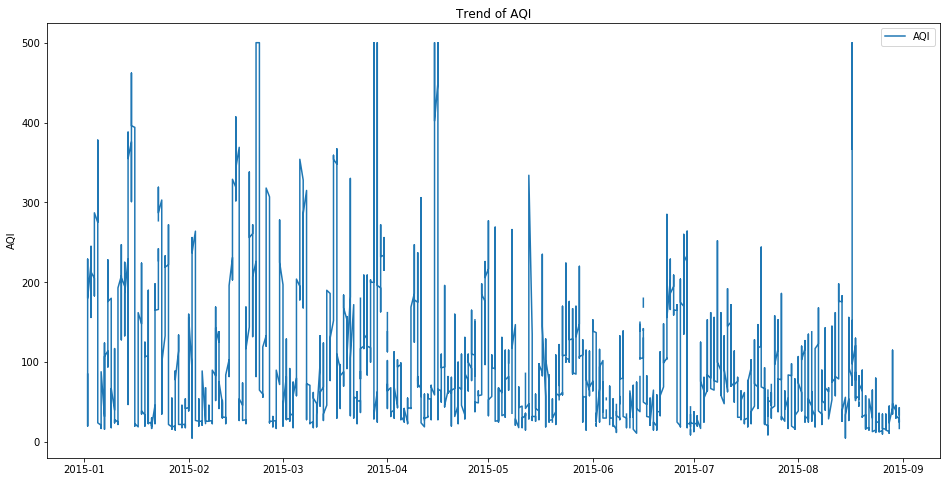

In [12]:
plt.figure(figsize=(16,8))
plt.plot(data_A3['date'],data_A3['AQI'])
plt.title('Trend of AQI')
plt.ylabel('AQI')
plt.legend(loc='best')

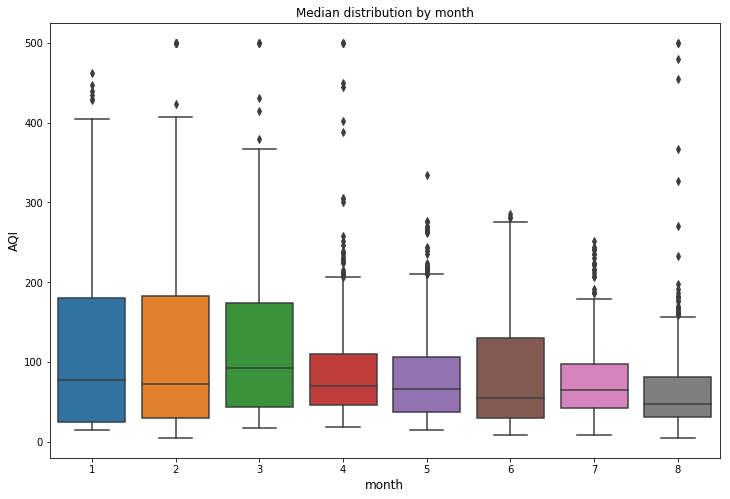

In [13]:
plt.figure(figsize=(12,8))
sns.boxplot(x='month', y='AQI', data=data_A3)
plt.ylabel('AQI', fontsize=12)
plt.xlabel('month', fontsize=12)
plt.title('Median distribution by month')
plt.show()

从上面箱线图看，和我们的判断是吻合的，前3个月AQI的中位数、上四分位数、上边缘都比较高，冬天空气较差。

下面我们从月、周、天尺度看一下AQI的一个基本情况。

# 月

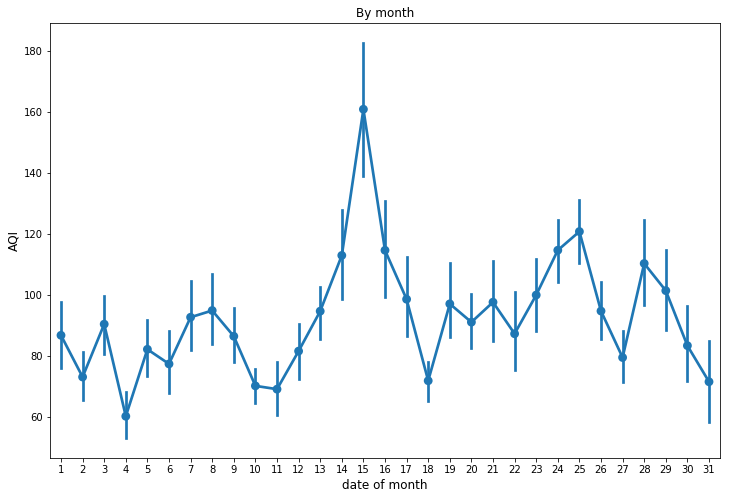

In [14]:
#month
plt.figure(figsize=(12,8))
sns.pointplot(x='day', y='AQI', data=data_A3)
plt.ylabel('AQI', fontsize=12)
plt.xlabel('date of month', fontsize=12)
plt.title('By month')
plt.show()

# 周

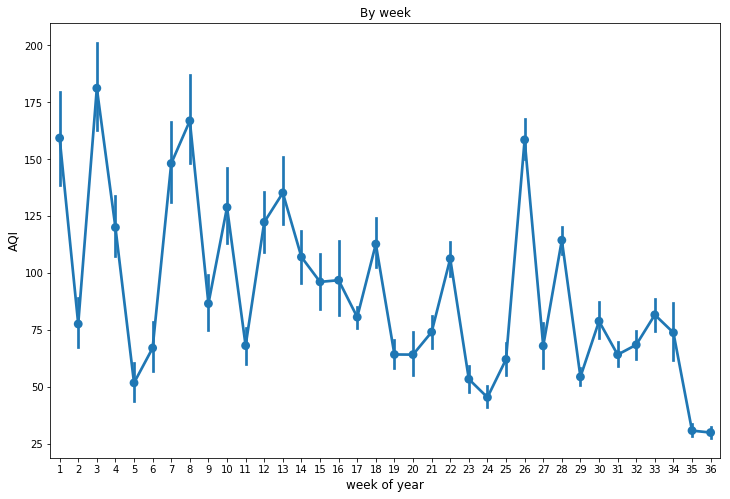

In [15]:
#week
plt.figure(figsize=(12,8))
sns.pointplot(x="week", y="AQI", data=data_A3)
plt.ylabel('AQI', fontsize=12)
plt.xlabel('week of year', fontsize=12)
plt.title('By week')
plt.show()

# 一天，24小时

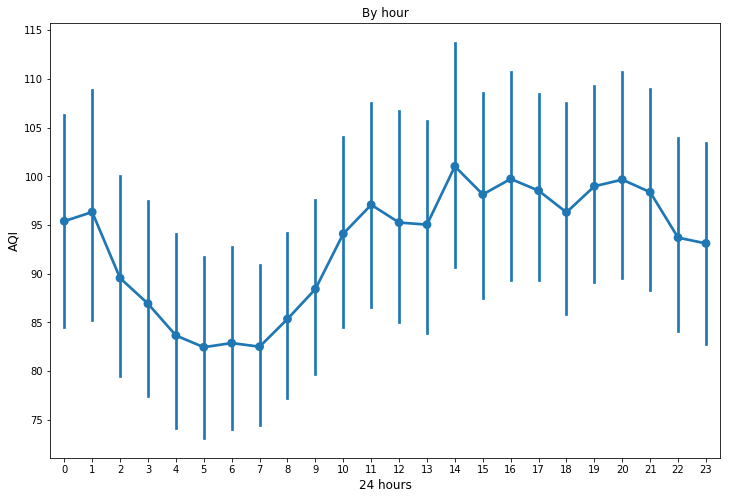

In [16]:
#one day
plt.figure(figsize=(12,8))
sns.pointplot(x="hour", y="AQI", data=data_A3)
plt.ylabel('AQI', fontsize=12)
plt.xlabel('24 hours', fontsize=12)
plt.title('By hour')
plt.show()

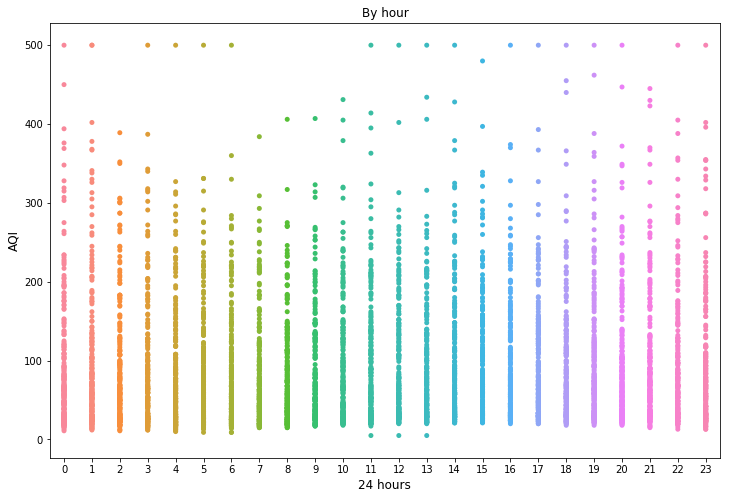

In [17]:
#one day---another way
plt.figure(figsize=(12,8))
sns.stripplot(x="hour", y="AQI", data=data_A3)
plt.ylabel('AQI', fontsize=12)
plt.xlabel('24 hours', fontsize=12)
plt.title('By hour')
plt.show()

从上面对AQI在时间尺度上的可视化结果，可以看出，AQI的变化趋势有时间上的周期性影响，因此，在之后的特征选择上需要考虑到时间因素。

下面，我们来分析一下AQI和6个指标的相关关系。首先我们不分地点计算相关性，然后再以A3为例进行可视化展示。

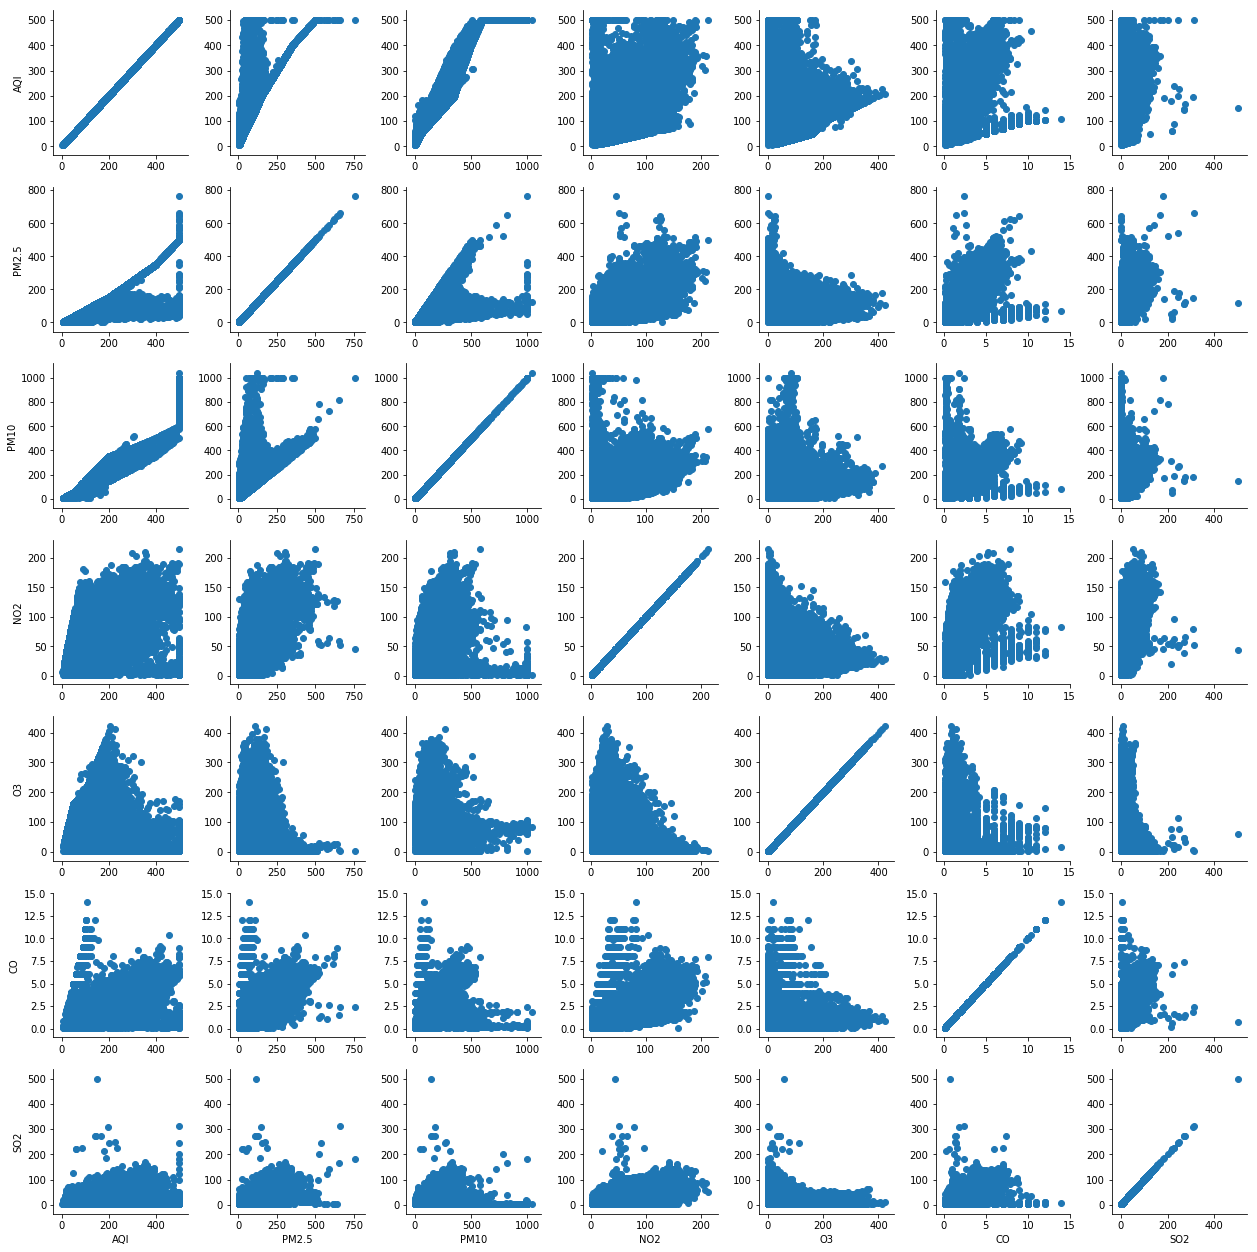

In [18]:
co_data=data[['AQI','PM2.5','PM10','NO2','O3','CO','SO2']]
g=sns.PairGrid(co_data)
g.map(plt.scatter)

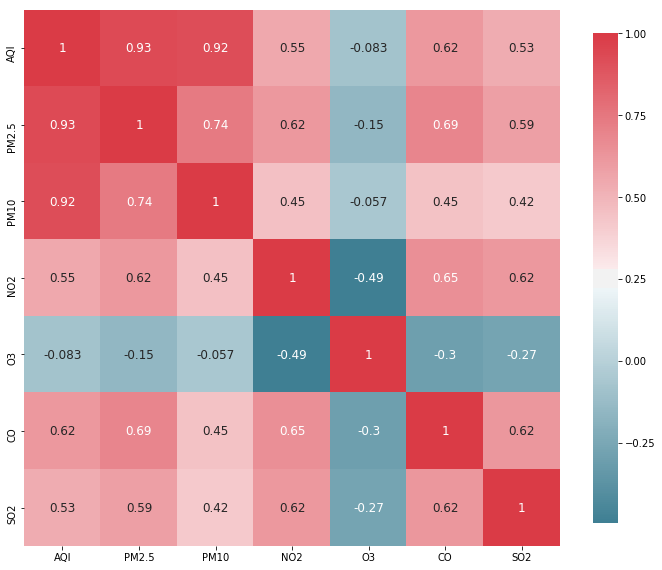

In [19]:
#相关性热度图
def plot_corr_map(df):
    corr=df.corr()
    _,ax=plt.subplots(figsize=(12,10))
    cmap=sns.diverging_palette(220,10,as_cmap=True)
    _=sns.heatmap(
        corr,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink':0.9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize':12})
plot_corr_map(co_data)

seaborn做出来的图还是很漂亮的，从上面的相关关系矩阵可以发现O3与AQI的相关性最低，基本没有相关性，原因估计也比较复杂，需要专业人士去解读。我按照自己的理解认为：（1）AQI计算时，O3 权重较小，NOx 权重较大，PM2.5 权重最大，O3与它们都是负相关；（2）按AQI计算规则，臭氧1小时浓度值不用于计算每天的AQI指数，仅用来反映小时健康影响程度，提示直接接触臭氧污染的人群应采取防护措施，而日均AQI指数计算采用臭氧8小时滑动平均值。

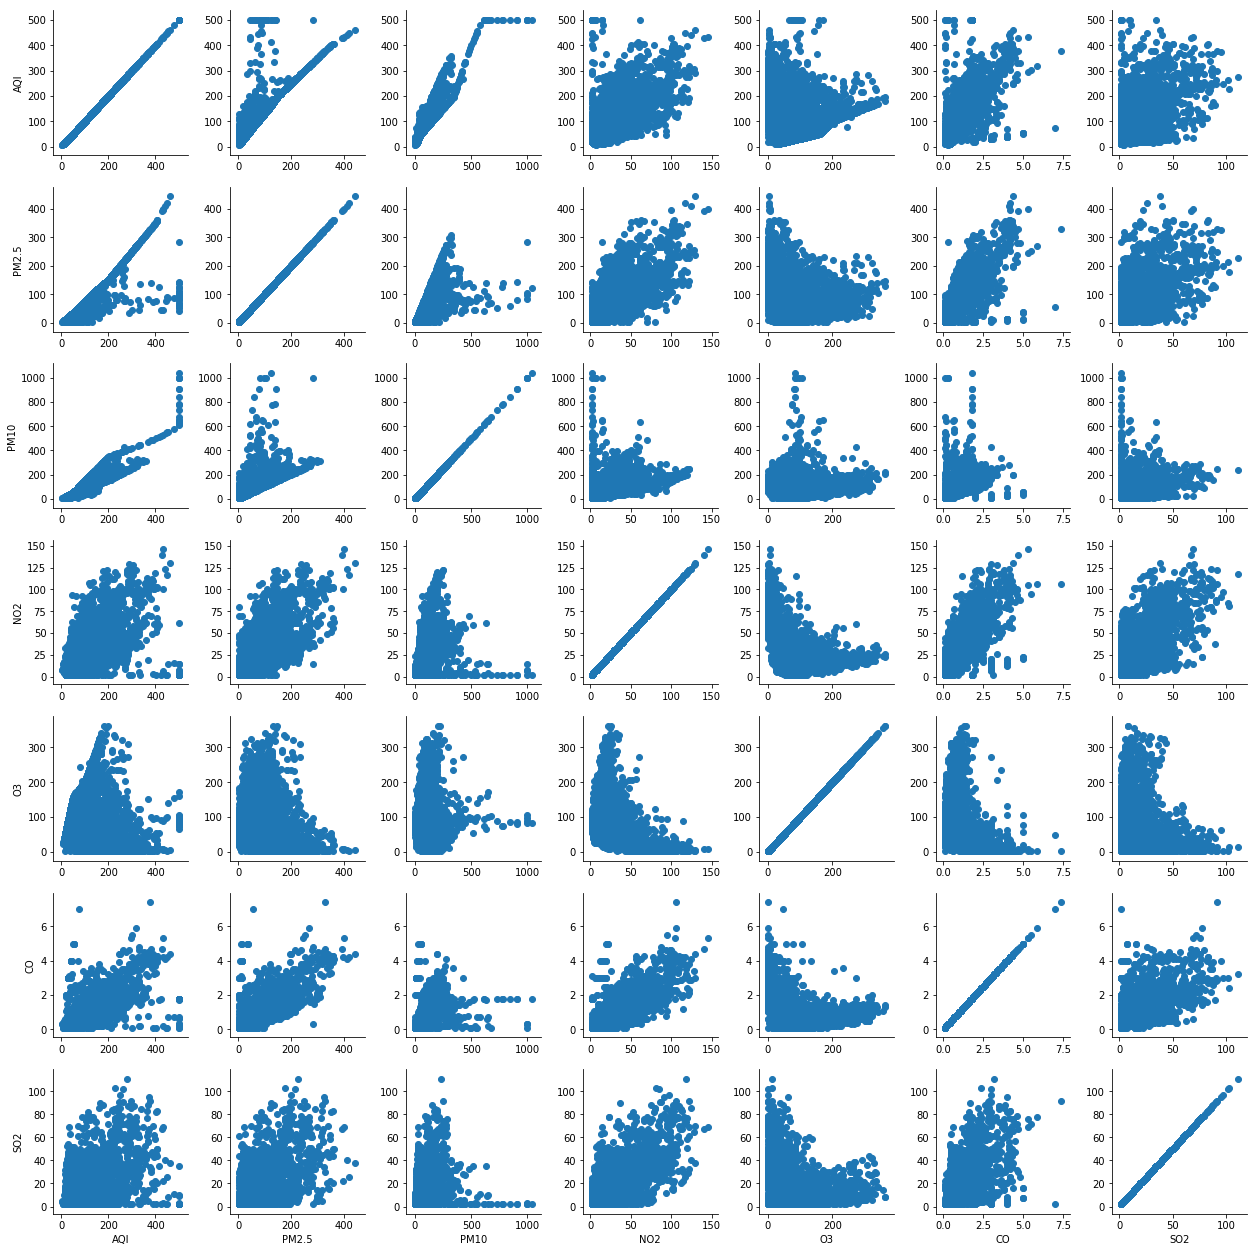

In [20]:
#地点A3的情况
co_data_A3=data_A3[['AQI','PM2.5','PM10','NO2','O3','CO','SO2']]
g=sns.PairGrid(co_data_A3)
g.map(plt.scatter)

通过上面对数据的挖掘和理解，可以发现，时间对AQI的影响相当重要，因此，在需要把Month、Week、Day、Hour等不同的时间尺度作为特征加入到数据去训练模型；另外，O3与AQI基本不存在相关性，因此，可以把O3从数据中删除，减少对训练模型的影响。

# 数据预处理

In [21]:
data.head()

,datetime,STATIONNAME,AQI,PM2.5,PM10,NO2,O3,CO,SO2,date,time,month,day,hour,week
0,2015/1/2 1:00,A1,145.0,111.0,140.0,102.0,2.0,2.7,61.0,2015-01-02,01:00:00,1,2,1,1
1,2015/1/2 1:00,A2,130.0,99.0,177.0,64.0,16.0,3.0,44.0,2015-01-02,01:00:00,1,2,1,1
2,2015/1/2 1:00,A3,85.0,34.0,120.0,10.0,56.0,0.4,10.0,2015-01-02,01:00:00,1,2,1,1
3,2015/1/2 1:00,A4,109.0,82.0,154.0,90.0,5.0,3.4,46.0,2015-01-02,01:00:00,1,2,1,1
4,2015/1/2 1:00,A5,127.0,96.0,132.0,89.0,4.0,3.4,62.0,2015-01-02,01:00:00,1,2,1,1


我们首先把不用的字段从表中删除，包括datetime、O3、date、time。

In [22]:
#remove old data features
data_new=data.drop(['datetime','O3','date','time'],axis=1)
data_new.head()

,STATIONNAME,AQI,PM2.5,PM10,NO2,CO,SO2,month,day,hour,week
0,A1,145.0,111.0,140.0,102.0,2.7,61.0,1,2,1,1
1,A2,130.0,99.0,177.0,64.0,3.0,44.0,1,2,1,1
2,A3,85.0,34.0,120.0,10.0,0.4,10.0,1,2,1,1
3,A4,109.0,82.0,154.0,90.0,3.4,46.0,1,2,1,1
4,A5,127.0,96.0,132.0,89.0,3.4,62.0,1,2,1,1


In [23]:
data_new.shape

(65460, 11)

缺失值处理

首先看一下表中数据缺失情况,时间数据还比较好，没有缺失；其他字段的话，除PM10缺失较多以外，AQI等缺失不算多，可由均值、中位数等进行填充，这里选择均值。

In [24]:
nans=pd.isnull(data_new).sum()
nans[nans>0]

AQI       1342
PM2.5     2092
PM10     19152
NO2       2213
CO        1700
SO2       1708
dtype: int64

In [25]:
#对AQI、PM2.5、NO2、03、CO和SO2采用均值填充
data_new['AQI']=data_new['AQI'].fillna(data_new['AQI'].mean())
data_new['PM2.5']=data_new['PM2.5'].fillna(data_new['PM2.5'].mean())
data_new['NO2']=data_new['NO2'].fillna(data_new['NO2'].mean())
data_new['CO']=data_new['CO'].fillna(data_new['CO'].mean())
data_new['SO2']=data_new['SO2'].fillna(data_new['SO2'].mean())

In [26]:
nans=pd.isnull(data_new).sum()
nans[nans>0]

PM10    19152
dtype: int64

对于PM10来说，缺失值小于1/3，但也缺失较多，考虑到其随机性因素，不能用均值等方法填充，这里采用随机森林建立模型的方法。

In [30]:
#采用随机森林算法建立模型来填充PM10的缺失值，即利用数据表中某些没有缺失的特征属性来预测某特征属性的缺失值
def fill_missing_PM10(df):
    from sklearn.ensemble import RandomForestRegressor
    temp=df[['PM10','AQI','PM2.5','NO2','CO','SO2']]
    #分成已知该特征和未知该特征两个部分
    known=temp[temp.PM10.notnull()].as_matrix() 
    unknown=temp[temp.PM10.isnull()].as_matrix()
    #X为特征属性值
    X=known[:,1:]
    #y为结果标签值
    y=known[:,0]
    #fit to a RandomForestRegressor model
    rfr=RandomForestRegressor(n_estimators=2000,n_jobs=-1)
    rfr.fit(X,y)
    #利用得到的model进行未知特征值预测
    predicted=rfr.predict(unknown[:,1:])
    #将预测结果fill the missing values
    df.loc[df.PM10.isnull(),'PM10']=predicted
    return df.rfr
#调用函数进行PM10缺失值填充
data_new.rfr=fill_missing_PM10(data_new)

KeyboardInterrupt: 

In [ ]:
data_new.head()

In [ ]:
data_new.info()

# 数值特征向量化

向量化是使用矩阵计算来代替for循环，以简化计算过程，提高效率。

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# 我们把连续值的特征放入一个dict中
feature_con=['PM2.5','PM10','NO2','CO','SO2','month','day','week','hour']
data_feature_con=data_new[feature_con]
X_con=data_feature_con.T.to_dict().values() 

# 向量化特征
vec=DictVectorizer(sparse=False)
X_con_vec=vec.fit_transform(X_con)

# data_feature_con.head()

In [32]:
X_con_vec

array([[   2.7      ,  102.       ,  140.       , ...,    1.       ,
           1.       ,    1.       ],
       [   3.       ,   64.       ,  177.       , ...,    1.       ,
           1.       ,    1.       ],
       [   0.4      ,   10.       ,  120.       , ...,    1.       ,
           1.       ,    1.       ],
       ..., 
       [   0.4      ,    5.       ,   18.       , ...,   23.       ,
           8.       ,   36.       ],
       [   0.6      ,   26.       ,   18.754    , ...,   23.       ,
           8.       ,   36.       ],
       [   0.5      ,   19.       ,   21.2185119, ...,   23.       ,
           8.       ,   36.       ]])

标准化数值型特征

对数型值属性做一些处理，把其值缩减至0-1之间，这样的数据放到模型里，对模型训练的收敛和模型的准确性都有好处。这里采用MinMaxScaler方法。

In [33]:
# normalize the con features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_con_vec=scaler.fit_transform(X_con_vec)
X_con_vec

array([[ 0.18705036,  0.47169811,  0.13043478, ...,  0.04347826,
         0.        ,  0.        ],
       [ 0.20863309,  0.29245283,  0.16618357, ...,  0.04347826,
         0.        ,  0.        ],
       [ 0.02158273,  0.03773585,  0.11111111, ...,  0.04347826,
         0.        ,  0.        ],
       ..., 
       [ 0.02158273,  0.01415094,  0.01256039, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.03597122,  0.11320755,  0.01328889, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.02877698,  0.08018868,  0.01567006, ...,  1.        ,
         1.        ,  1.        ]])

# 类别特征处理

对于类别特征，通过one_hot编码进行处理，采用pandas的get_dummies函数。

In [34]:
#one-hot encoding
dummies_cat_feature=pd.get_dummies(data_new['STATIONNAME'])
dummies_cat_feature=dummies_cat_feature.rename(columns=lambda x: "STATIONNAME_"+str(x))
dummies_cat_feature.head()

,STATIONNAME_A1,STATIONNAME_A10,STATIONNAME_A11,STATIONNAME_A12,STATIONNAME_A2,STATIONNAME_A3,STATIONNAME_A4,STATIONNAME_A5,STATIONNAME_A6,STATIONNAME_A7,STATIONNAME_A8,STATIONNAME_A9
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0


In [35]:
# 同样，把编码后的表放入dict中
X_cat=dummies_cat_feature.T.to_dict().values() 
X_cat
# 向量化特征
X_cat_vec=vec.fit_transform(X_cat)

In [36]:
X_cat_vec

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

# 把特征组合起来

In [37]:
# combine cat & con features
X_vec=np.concatenate((X_con_vec,X_cat_vec),axis=1)
X_vec

array([[ 0.18705036,  0.47169811,  0.13043478, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20863309,  0.29245283,  0.16618357, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02158273,  0.03773585,  0.11111111, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.02158273,  0.01415094,  0.01256039, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03597122,  0.11320755,  0.01328889, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02877698,  0.08018868,  0.01567006, ...,  0.        ,
         0.        ,  0.        ]])

# 同理，处理一下AQI值

In [38]:
#对AQI向量化
Y_vec=data_new['AQI'].values.astype(float)
#对AQI最大最小化
Y_vec=scaler.fit_transform(Y_vec)
Y_vec

/Users/wanmen/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/wanmen/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.28427419,  0.25403226,  0.16330645, ...,  0.03427419,
        0.03629032,  0.04233871])

# 建模

这里，我们采用多种模型进行建模，包括LinearRegression、LogisticRegression、ExtraTreesRegressor等。

首先，我们采用交叉验证的方式拆分训练集和测试集。

In [39]:
from sklearn import cross_validation
X_train,X_test,y_train,y_test=cross_validation.train_test_split(X_vec,Y_vec,test_size=0.3,random_state=0)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(45822, 21)
(19638, 21)
(45822,)
(19638,)


/Users/wanmen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


为验证结果的好坏，每个模型需要进行评估，这里，为简化流程，把所有的评估项放在一个函数里。

In [40]:
def model_evaluation(model,X_tr,y_tr,X_te,y_te):
    from sklearn import metrics
    from sklearn.cross_validation import cross_val_score
    #建立模型
    model.fit(X_tr,y_tr)
    #预测
    y_pr=model.predict(X_te)
    #打印结果
    print ("Correlation Coefficient:",np.corrcoef(y_te,y_pr))
    print ("---------------------------")
    print ("RMSE:",np.sqrt(metrics.mean_squared_error(y_te, y_pr)))
    print ("---------------------------")
    print ("Determination Coefficient(R2):train score",model.score(X_tr,y_tr),"test score",model.score(X_te,y_te))
    print ("---------------------------")
    scores=cross_val_score(model,X_tr,y_tr)
    print ("Cross-validation score:",scores.mean())
    return model,y_pr

关于模型结果的评价标准，大家可以到http://scikit-learn.org/stable/modules/model_evaluation.html去看。

# 线性回归

第一种模型采用最简单的线性回归进行学习预测。

In [41]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
m,y_predict_linear=model_evaluation(lr,X_train,y_train,X_test,y_test)

('Correlation Coefficient:', array([[ 1.        ,  0.98070837],
       [ 0.98070837,  1.        ]]))
---------------------------
('RMSE:', 0.031087398333189735)
---------------------------
('Determination Coefficient(R2):train score', 0.96269980121863874, 'test score', 0.96177207197519732)
---------------------------
('Cross-validation score:', 0.96265440733624652)


In [42]:
y_predict_linear

array([ 0.28225708,  0.0422821 ,  0.26501465, ...,  0.05900574,
        0.04971313,  0.04841614])

# 神经网络

In [43]:
from sklearn.neural_network import MLPRegressor
mlpr=MLPRegressor(hidden_layer_sizes=(1000,),activation='relu',max_iter=500)
model_evaluation(mlpr,X_train,y_train,X_test,y_test)

('Correlation Coefficient:', array([[ 1.        ,  0.98801212],
       [ 0.98801212,  1.        ]]))
---------------------------
('RMSE:', 0.025436980097318266)
---------------------------
('Determination Coefficient(R2):train score', 0.97624999102569732, 'test score', 0.97440570896495338)
---------------------------
('Cross-validation score:', 0.97338054334231039)


(MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(1000,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=500, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False),
 array([ 0.26448477,  0.02705985,  0.24896281, ...,  0.05591071,
         0.03665071,  0.04474823]))

# 决策树回归

In [44]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor()
model_evaluation(dtr,X_train,y_train,X_test,y_test)

('Correlation Coefficient:', array([[ 1.        ,  0.99556751],
       [ 0.99556751,  1.        ]]))
---------------------------
('RMSE:', 0.014962531976911718)
---------------------------
('Determination Coefficient(R2):train score', 0.9999997848944423, 'test score', 0.99114431445605455)
---------------------------
('Cross-validation score:', 0.99011878673061782)


(DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
 array([ 0.26008065,  0.03427419,  0.28830645, ...,  0.0625    ,
         0.03225806,  0.03225806]))

# ensemble方法——极端随机树回归

Extra_Tree是一种bagging方法，是基于极端随机树的迭代算法，与随机森林相比，模型会进一步减少方差。

In [45]:
from sklearn.ensemble import ExtraTreesRegressor
params = {'n_estimators': 50, 'random_state': np.random.RandomState(1)}
etr= ExtraTreesRegressor(**params)
model_evaluation(etr,X_train,y_train,X_test,y_test)

('Correlation Coefficient:', array([[ 1.        ,  0.99800697],
       [ 0.99800697,  1.        ]]))
---------------------------
('RMSE:', 0.010044709043094111)
---------------------------
('Determination Coefficient(R2):train score', 0.99999997796229767, 'test score', 0.99600895406336976)
---------------------------
('Cross-validation score:', 0.99552631354988697)


(ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False,
           random_state=<mtrand.RandomState object at 0x12210ea50>,
           verbose=0, warm_start=False),
 array([ 0.26008065,  0.03439516,  0.28822581, ...,  0.04879032,
         0.03383147,  0.03629032]))